# Perovskite Materials: Comprehensive Data Analysis
## Machine Learning for Solar Cell Material Discovery

This notebook provides a complete analysis of perovskite materials for solar cell applications, including:
- Data loading and preprocessing 
- Physics-based feature engineering
- Band gap and stability prediction models
- Feature importance analysis
- Material discovery design maps

**Project Structure:**
- `data/`: Raw and processed datasets
- `scripts/`: Individual analysis scripts  
- `results/plots/`: Generated visualizations
- `models/`: Trained machine learning models

In [12]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries loaded successfully!")
print("Ready for perovskite materials analysis 🔬")

Libraries loaded successfully!
Ready for perovskite materials analysis 🔬


## 1. Data Loading and Preprocessing

We start by loading the raw perovskite materials data and filtering for ABX3 crystal structures that are characteristic of perovskite materials.

In [13]:
# Load the raw perovskite data
try:
    df_raw = pd.read_csv('../data/Perovskite_data.csv')
    print(f"✅ Loaded {len(df_raw)} materials from raw dataset")
    print(f"Columns: {list(df_raw.columns)}")
except FileNotFoundError:
    print("❌ Raw data file not found. Please ensure 'Perovskite_data.csv' is in the data directory.")

# Display basic information about the dataset
print(f"\nDataset shape: {df_raw.shape}")
print(f"Memory usage: {df_raw.memory_usage(deep=True).sum() / 1024**2:.1f} MB")
df_raw.head()

✅ Loaded 4557 materials from raw dataset
Columns: ['mp_id', 'formula', 'sites', 'composition', 'a_edge (angstrom)', 'b_edge (angstrom)', 'c_edge (angstrom)', 'alpha_ang (deg)', 'beta_ang (deg)', 'gamma_ang (deg)', 'crystal_system', 'space_group', 'total_magnetisation (bohr)', 'energy_per_atom (eV/atom)', 'formation_energy (eV/atom)', 'energy_above_hull (eV/atom)', 'stable', 'density (g/cc)', 'band_gap (eV)', 'direct_bandgap', 'volume (cubic-angstrom)', 'bulk_modulus (GPa)', 'shear_modulus (GPa)']

Dataset shape: (4557, 23)
Memory usage: 2.1 MB


,mp_id,formula,sites,composition,a_edge (angstrom),b_edge (angstrom),c_edge (angstrom),alpha_ang (deg),beta_ang (deg),gamma_ang (deg),...,energy_per_atom (eV/atom),formation_energy (eV/atom),energy_above_hull (eV/atom),stable,density (g/cc),band_gap (eV),direct_bandgap,volume (cubic-angstrom),bulk_modulus (GPa),shear_modulus (GPa)
0,mp-1183115,AcAlO3,5,Ac1 Al1 O3,3.858634,3.858634,3.858634,90.000000,90.0,90.0,...,-8.232146,-3.690019,0.000000,True,8.728230,4.1024,True,57.451413,NaN,NaN
1,mp-1183052,AcBO3,5,Ac1 B1 O3,3.721668,3.721668,3.721668,90.000000,90.0,90.0,...,-7.604280,-2.475390,0.792473,False,9.206879,0.8071,False,51.548126,NaN,NaN
2,mp-866101,AcCrO3,5,Ac1 Cr1 O3,3.944287,3.944302,3.944272,90.000000,90.0,90.0,...,-8.862593,-3.138972,0.000000,True,8.848788,2.0031,False,61.362845,NaN,NaN
3,mp-864606,AcCuO3,5,Ac1 Cu1 O3,3.913331,3.913331,3.913331,90.000000,90.0,90.0,...,-7.035745,-2.422892,0.000000,True,9.380471,0.0000,False,59.929387,"{'voigt': 163.571, 'reuss': 163.571, 'vrh': 16...","{'voigt': 81.813, 'reuss': 81.632, 'vrh': 81.723}"
4,mp-861502,AcFeO3,5,Ac1 Fe1 O3,3.953570,3.953568,3.953585,90.000092,90.0,90.0,...,-8.258555,-2.771539,0.000000,True,8.889999,0.9888,False,61.797311,NaN,NaN


In [14]:
# Define functions to identify and filter perovskite structures (ABX3)
def is_perovskite_formula(formula):
    """Check if a chemical formula follows ABX3 structure"""
    elements = formula.strip().split()
    if len(elements) != 3:
        return False
    
    element_counts = {}
    for element in elements:
        match = re.match(r'([A-Za-z]+)(\d+)', element)
        if not match:
            return False
        elem, count = match.groups()
        element_counts[elem] = int(count)
    
    counts = list(element_counts.values())
    counts.sort()
    return counts == [1, 1, 3]

def extract_abx_sites(formula):
    """Extract A, B, and X site elements from chemical formula"""
    elements = formula.strip().split()
    element_counts = {}
    for element in elements:
        match = re.match(r'([A-Za-z]+)(\d+)', element)
        elem, count = match.groups()
        element_counts[elem] = int(count)
    
    a_site = None
    b_site = None
    x_site = None
    
    for elem, count in element_counts.items():
        if count == 3:
            x_site = elem
        elif count == 1:
            if a_site is None:
                a_site = elem
            else:
                b_site = elem
    
    return a_site, b_site, x_site

# Filter for perovskite structures
print("Filtering for ABX3 perovskite structures...")
perovskite_mask = df_raw['composition'].apply(is_perovskite_formula)
df_filtered = df_raw[perovskite_mask].copy()

# Extract A, B, X sites
a_sites, b_sites, x_sites = zip(*df_filtered['composition'].apply(extract_abx_sites))
df_filtered['A_site'] = a_sites
df_filtered['B_site'] = b_sites
df_filtered['X_site'] = x_sites

print(f"✅ Found {len(df_filtered)} perovskite materials ({len(df_filtered)/len(df_raw)*100:.1f}% of total)")

# Show some examples
print("\nExample perovskite compositions:")
df_filtered[['composition', 'A_site', 'B_site', 'X_site']].head(10)

Filtering for ABX3 perovskite structures...
✅ Found 4557 perovskite materials (100.0% of total)

Example perovskite compositions:


,composition,A_site,B_site,X_site
0,Ac1 Al1 O3,Ac,Al,O
1,Ac1 B1 O3,Ac,B,O
2,Ac1 Cr1 O3,Ac,Cr,O
3,Ac1 Cu1 O3,Ac,Cu,O
4,Ac1 Fe1 O3,Ac,Fe,O
5,Ac1 Ga1 O3,Ac,Ga,O
6,Ac1 Mg1 O3,Ac,Mg,O
7,Ac1 Mn1 O3,Ac,Mn,O
8,Ac1 Ni1 O3,Ac,Ni,O
9,Ac1 Pd1 O3,Ac,Pd,O


## 2. Feature Engineering with Physics-Based Properties

Now we'll calculate physics-based features that are crucial for understanding perovskite stability and electronic properties:

- **Tolerance Factor**: Goldschmidt tolerance factor t = (r_A + r_X)/(√2*(r_B + r_X))
- **Octahedral Factor**: μ = r_B/r_X  
- **Electronegativity Values**: Pauling electronegativity for each site
- **Electronegativity Difference**: |EN_B - EN_X|

In [15]:
# Comprehensive element database with ionic radii and electronegativity
ELEMENT_DB = {
    # A-site elements (large cations)
    'Cs': {'ionic_radius': 1.88, 'electronegativity': 0.79},
    'Rb': {'ionic_radius': 1.72, 'electronegativity': 0.82},
    'K': {'ionic_radius': 1.64, 'electronegativity': 0.82},
    'Na': {'ionic_radius': 1.39, 'electronegativity': 0.93},
    'Li': {'ionic_radius': 1.36, 'electronegativity': 0.98},
    'Ba': {'ionic_radius': 1.61, 'electronegativity': 0.89},
    'Sr': {'ionic_radius': 1.44, 'electronegativity': 0.95},
    'Ca': {'ionic_radius': 1.12, 'electronegativity': 1.0},
    
    # B-site elements (transition metals and post-transition metals)
    'Pb': {'ionic_radius': 1.19, 'electronegativity': 2.33},
    'Sn': {'ionic_radius': 1.18, 'electronegativity': 1.96},
    'Ge': {'ionic_radius': 0.73, 'electronegativity': 2.01},
    'Ti': {'ionic_radius': 0.605, 'electronegativity': 1.54},
    'Zr': {'ionic_radius': 0.72, 'electronegativity': 1.33},
    'Al': {'ionic_radius': 0.535, 'electronegativity': 1.61},
    'Mn': {'ionic_radius': 0.83, 'electronegativity': 1.55},
    'Fe': {'ionic_radius': 0.78, 'electronegativity': 1.83},
    'Cr': {'ionic_radius': 0.615, 'electronegativity': 1.66},
    'Cu': {'ionic_radius': 0.73, 'electronegativity': 1.9},
    'B': {'ionic_radius': 0.27, 'electronegativity': 2.04},
    'Ac': {'ionic_radius': 1.12, 'electronegativity': 1.1},
    
    # X-site elements (anions)
    'I': {'ionic_radius': 2.20, 'electronegativity': 2.66},
    'Br': {'ionic_radius': 1.96, 'electronegativity': 2.96},
    'Cl': {'ionic_radius': 1.81, 'electronegativity': 3.16},
    'F': {'ionic_radius': 1.33, 'electronegativity': 3.98},
    'O': {'ionic_radius': 1.40, 'electronegativity': 3.44},
    'S': {'ionic_radius': 1.84, 'electronegativity': 2.58},
    
    # Default for unknown elements
    'DEFAULT': {'ionic_radius': 1.0, 'electronegativity': 2.0}
}

def get_element_properties(element):
    """Get ionic radius and electronegativity for an element"""
    return ELEMENT_DB.get(element, ELEMENT_DB['DEFAULT'])

print(f"Element database contains {len(ELEMENT_DB)-1} elements")
print("Sample element properties:", ELEMENT_DB['Pb'])

Element database contains 26 elements
Sample element properties: {'ionic_radius': 1.19, 'electronegativity': 2.33}


In [16]:
# Calculate physics-based features
print("Calculating tolerance factors and other physics-based features...")

tolerance_factors = []
octahedral_factors = []
a_electronegativities = []
b_electronegativities = []
x_electronegativities = []
en_differences = []

for idx, row in df_filtered.iterrows():
    try:
        # Get element properties
        a_props = get_element_properties(row['A_site'])
        b_props = get_element_properties(row['B_site'])
        x_props = get_element_properties(row['X_site'])
        
        # Extract ionic radii and electronegativities
        r_a, r_b, r_x = a_props['ionic_radius'], b_props['ionic_radius'], x_props['ionic_radius']
        en_a, en_b, en_x = a_props['electronegativity'], b_props['electronegativity'], x_props['electronegativity']
        
        # Calculate tolerance factor: t = (r_A + r_X)/(√2*(r_B + r_X))
        tolerance_factor = (r_a + r_x) / (np.sqrt(2) * (r_b + r_x)) if (r_b + r_x) > 0 else np.nan
        
        # Calculate octahedral factor: μ = r_B/r_X
        octahedral_factor = r_b / r_x if r_x > 0 else np.nan
        
        # Store calculated values
        tolerance_factors.append(tolerance_factor)
        octahedral_factors.append(octahedral_factor)
        a_electronegativities.append(en_a)
        b_electronegativities.append(en_b)
        x_electronegativities.append(en_x)
        en_differences.append(abs(en_b - en_x))
        
    except Exception as e:
        # If any error occurs for a single row, append NaN values and continue
        print(f"Warning: Skipping row {idx} due to error: {e}")
        tolerance_factors.append(np.nan)
        octahedral_factors.append(np.nan)
        a_electronegativities.append(np.nan)
        b_electronegativities.append(np.nan)
        x_electronegativities.append(np.nan)
        en_differences.append(np.nan)

# Add features to dataframe
df_filtered['tolerance_factor'] = tolerance_factors
df_filtered['octahedral_factor'] = octahedral_factors
df_filtered['A_site_en'] = a_electronegativities
df_filtered['B_site_en'] = b_electronegativities
df_filtered['X_site_en'] = x_electronegativities
df_filtered['en_difference'] = en_differences

# Save enhanced dataset
df_filtered.to_csv('../data/perovskite_features.csv', index=False)
print(f"✅ Enhanced dataset saved with {len(df_filtered)} samples and 6 new physics-based features")

# Display feature statistics
feature_cols = ['tolerance_factor', 'octahedral_factor', 'A_site_en', 'B_site_en', 'X_site_en', 'en_difference']
print(f"\nPhysics-based feature statistics:")
df_filtered[feature_cols].describe()

Calculating tolerance factors and other physics-based features...
✅ Enhanced dataset saved with 4557 samples and 6 new physics-based features

Physics-based feature statistics:


,tolerance_factor,octahedral_factor,A_site_en,B_site_en,X_site_en,en_difference
count,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000,4557.000000
mean,0.771219,0.749229,1.575521,1.996107,3.026142,1.154437
std,0.126875,0.295793,0.534803,0.354743,0.726978,0.672582
min,0.370828,0.146739,0.790000,0.820000,0.790000,0.000000
25%,0.707107,0.586466,0.950000,2.000000,2.580000,0.580000
50%,0.707107,0.714286,2.000000,2.000000,3.440000,1.440000
75%,0.859995,0.842857,2.000000,2.000000,3.440000,1.440000
max,1.603518,3.703704,3.440000,3.980000,3.980000,3.050000


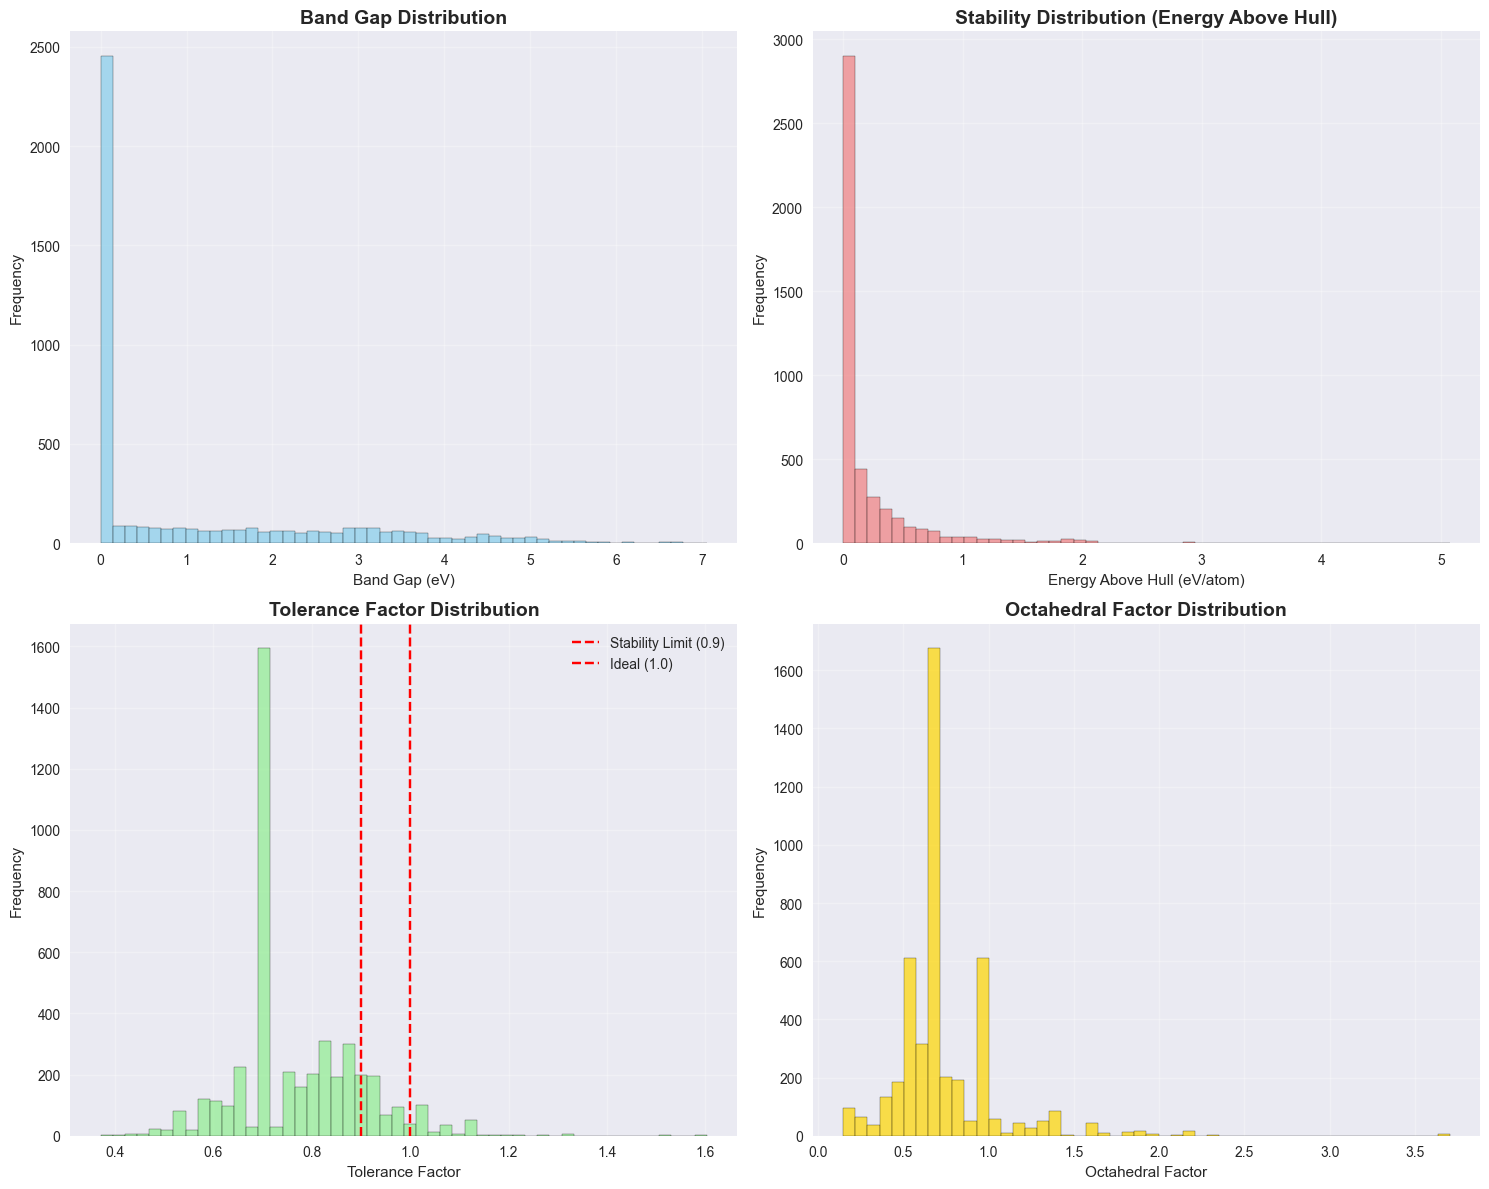

✅ Distribution plots saved to 'results/plots/distributions.png'


In [17]:
# Create comprehensive data visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Band gap distribution
axes[0,0].hist(df_filtered['band_gap (eV)'].dropna(), bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Band Gap Distribution', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Band Gap (eV)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].grid(True, alpha=0.3)

# Energy above hull distribution
axes[0,1].hist(df_filtered['energy_above_hull (eV/atom)'].dropna(), bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
axes[0,1].set_title('Stability Distribution (Energy Above Hull)', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Energy Above Hull (eV/atom)')
axes[0,1].set_ylabel('Frequency')
axes[0,1].grid(True, alpha=0.3)

# Tolerance factor distribution
axes[1,0].hist(df_filtered['tolerance_factor'].dropna(), bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1,0].set_title('Tolerance Factor Distribution', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Tolerance Factor')
axes[1,0].set_ylabel('Frequency')
axes[1,0].axvline(x=0.9, color='red', linestyle='--', label='Stability Limit (0.9)')
axes[1,0].axvline(x=1.0, color='red', linestyle='--', label='Ideal (1.0)')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Octahedral factor distribution
axes[1,1].hist(df_filtered['octahedral_factor'].dropna(), bins=50, alpha=0.7, color='gold', edgecolor='black')
axes[1,1].set_title('Octahedral Factor Distribution', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('Octahedral Factor')
axes[1,1].set_ylabel('Frequency')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Distribution plots saved to 'results/plots/distributions.png'")

## 3. Train Band Gap Prediction Model

We'll train a gradient boosting model to predict the band gap of perovskite materials based on the calculated physics-based features.

In [18]:
# Prepare data for band gap prediction
df_bandgap = df_filtered.dropna(subset=['band_gap (eV)']).copy()
print(f"Training band gap model on {len(df_bandgap)} materials with valid band gap data")

# Define features and target for band gap prediction
feature_cols_to_drop = [
    'mp_id', 'composition', 'A_site', 'B_site', 'X_site',
    'crystal_system', 'space_group', 'band_gap (eV)', 'energy_above_hull (eV/atom)'
]

# Only drop columns that actually exist in the dataframe
existing_cols_to_drop = [col for col in feature_cols_to_drop if col in df_bandgap.columns]
X_bandgap = df_bandgap.drop(columns=existing_cols_to_drop).fillna(0)

# Ensure we only use numeric columns
numeric_cols = X_bandgap.select_dtypes(include=[np.number]).columns
X_bandgap = X_bandgap[numeric_cols]

y_bandgap = df_bandgap['band_gap (eV)']

print(f"Features used for band gap prediction: {list(X_bandgap.columns)}")
print(f"Number of features: {len(X_bandgap.columns)}")

# Split data
X_train_bg, X_test_bg, y_train_bg, y_test_bg = train_test_split(
    X_bandgap, y_bandgap, test_size=0.2, random_state=42
)

# Train gradient boosting model
print("Training Gradient Boosting Regressor for band gap prediction...")
bandgap_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
bandgap_model.fit(X_train_bg, y_train_bg)

# Make predictions and evaluate
bg_predictions = bandgap_model.predict(X_test_bg)
bg_r2 = r2_score(y_test_bg, bg_predictions)
bg_mae = mean_absolute_error(y_test_bg, bg_predictions)

print(f"\n--- BAND GAP MODEL PERFORMANCE ---")
print(f"R-squared (R²): {bg_r2:.4f}")
print(f"Mean Absolute Error (MAE): {bg_mae:.4f} eV")
print(f"Training samples: {len(X_train_bg)}")
print(f"Testing samples: {len(X_test_bg)}")

# Save the model
joblib.dump(bandgap_model, '../models/band_gap_model.joblib')
print("✅ Band gap model saved to 'models/band_gap_model.joblib'")

Training band gap model on 4557 materials with valid band gap data
Features used for band gap prediction: ['sites', 'a_edge (angstrom)', 'b_edge (angstrom)', 'c_edge (angstrom)', 'alpha_ang (deg)', 'beta_ang (deg)', 'gamma_ang (deg)', 'total_magnetisation (bohr)', 'energy_per_atom (eV/atom)', 'formation_energy (eV/atom)', 'density (g/cc)', 'volume (cubic-angstrom)', 'tolerance_factor', 'octahedral_factor', 'A_site_en', 'B_site_en', 'X_site_en', 'en_difference']
Number of features: 18
Training Gradient Boosting Regressor for band gap prediction...

--- BAND GAP MODEL PERFORMANCE ---
R-squared (R²): 0.7309
Mean Absolute Error (MAE): 0.5248 eV
Training samples: 3645
Testing samples: 912
✅ Band gap model saved to 'models/band_gap_model.joblib'


## 4. Train Stability Prediction Model

Now we'll train a second model to predict material stability using energy above hull as the target property.

In [19]:
# Prepare data for stability prediction
df_stability = df_filtered.dropna(subset=['energy_above_hull (eV/atom)']).copy()
print(f"Training stability model on {len(df_stability)} materials with valid stability data")

# Use same feature selection approach as band gap model
existing_cols_to_drop = [col for col in feature_cols_to_drop if col in df_stability.columns]
X_stability = df_stability.drop(columns=existing_cols_to_drop).fillna(0)

# Ensure we only use numeric columns
numeric_cols = X_stability.select_dtypes(include=[np.number]).columns
X_stability = X_stability[numeric_cols]

y_stability = df_stability['energy_above_hull (eV/atom)']

print(f"Features used for stability prediction: {list(X_stability.columns)}")
print(f"Number of features: {len(X_stability.columns)}")

# Split data
X_train_st, X_test_st, y_train_st, y_test_st = train_test_split(
    X_stability, y_stability, test_size=0.2, random_state=42
)

# Train gradient boosting model for stability
print("Training Gradient Boosting Regressor for stability prediction...")
stability_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
stability_model.fit(X_train_st, y_train_st)

# Make predictions and evaluate
st_predictions = stability_model.predict(X_test_st)
st_r2 = r2_score(y_test_st, st_predictions)
st_mae = mean_absolute_error(y_test_st, st_predictions)

print(f"\n--- STABILITY MODEL PERFORMANCE ---")
print(f"R-squared (R²): {st_r2:.4f}")
print(f"Mean Absolute Error (MAE): {st_mae:.4f} eV/atom")
print(f"Training samples: {len(X_train_st)}")
print(f"Testing samples: {len(X_test_st)}")

# Save the model
joblib.dump(stability_model, '../models/stability_model.joblib')
print("✅ Stability model saved to 'models/stability_model.joblib'")

Training stability model on 4554 materials with valid stability data
Features used for stability prediction: ['sites', 'a_edge (angstrom)', 'b_edge (angstrom)', 'c_edge (angstrom)', 'alpha_ang (deg)', 'beta_ang (deg)', 'gamma_ang (deg)', 'total_magnetisation (bohr)', 'energy_per_atom (eV/atom)', 'formation_energy (eV/atom)', 'density (g/cc)', 'volume (cubic-angstrom)', 'tolerance_factor', 'octahedral_factor', 'A_site_en', 'B_site_en', 'X_site_en', 'en_difference']
Number of features: 18
Training Gradient Boosting Regressor for stability prediction...

--- STABILITY MODEL PERFORMANCE ---
R-squared (R²): 0.8479
Mean Absolute Error (MAE): 0.1057 eV/atom
Training samples: 3643
Testing samples: 911
✅ Stability model saved to 'models/stability_model.joblib'


## 5. Feature Importance Analysis

Understanding which features are most important for each prediction helps us gain scientific insight into what drives perovskite properties.

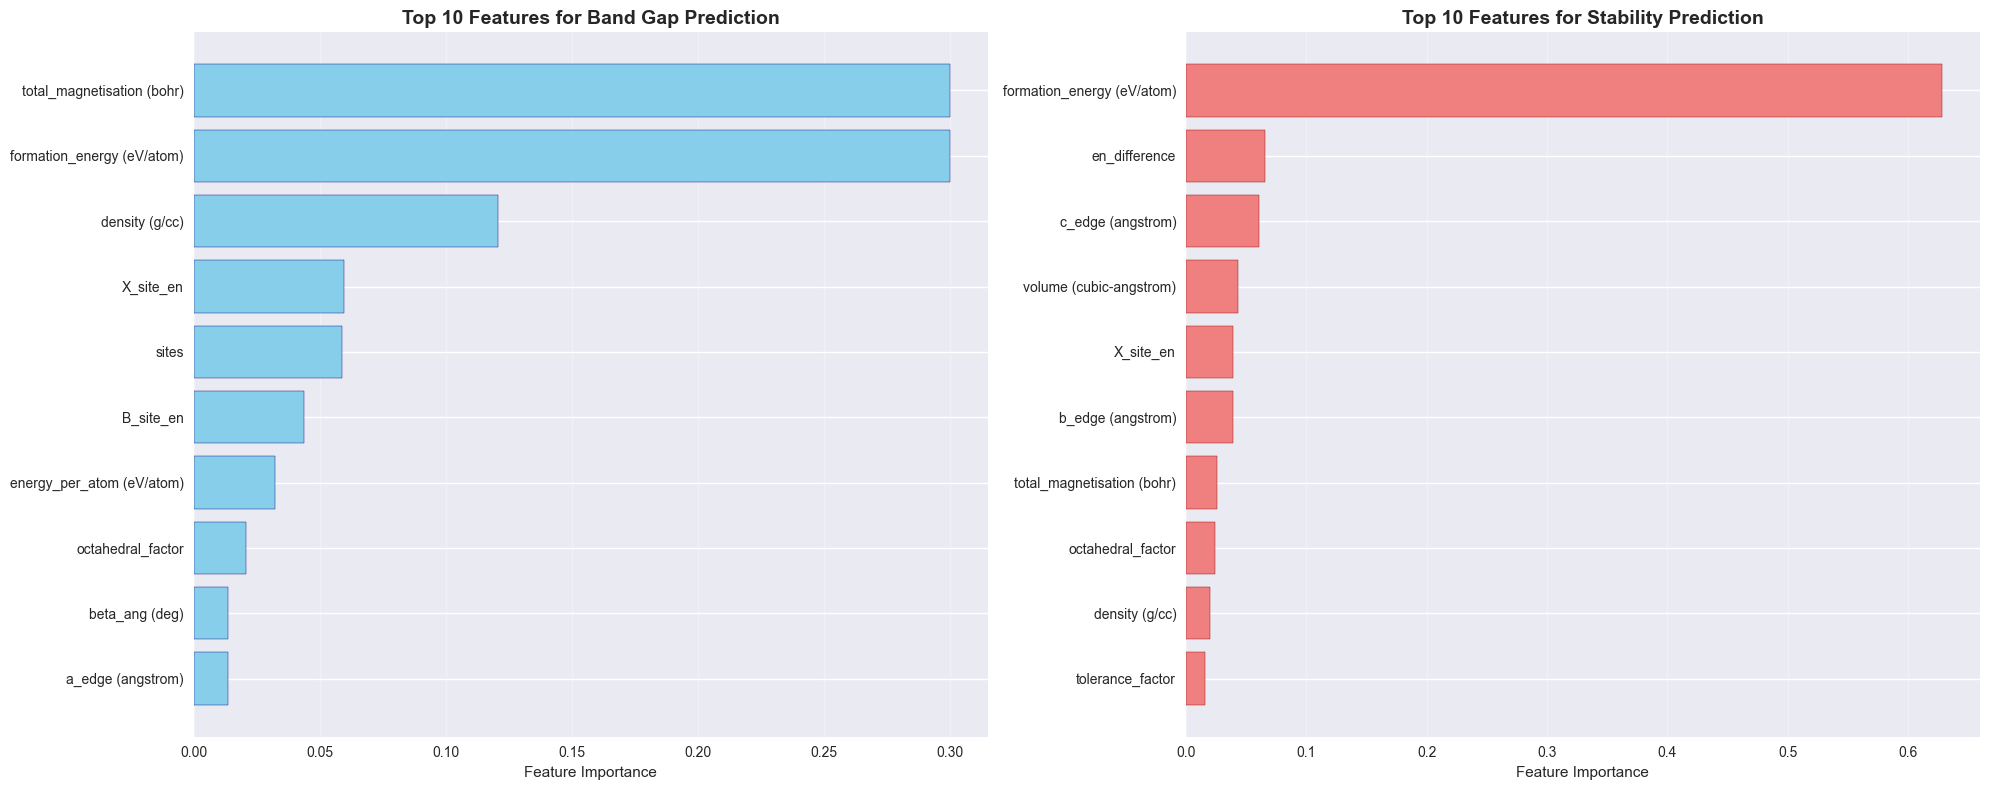

TOP 5 MOST IMPORTANT FEATURES:

For Band Gap Prediction:
  1. total_magnetisation (bohr): 0.3000
  2. formation_energy (eV/atom): 0.2999
  3. density (g/cc): 0.1206
  4. X_site_en: 0.0597
  5. sites: 0.0588

For Stability Prediction:
  1. formation_energy (eV/atom): 0.6282
  2. en_difference: 0.0655
  3. c_edge (angstrom): 0.0606
  4. volume (cubic-angstrom): 0.0429
  5. X_site_en: 0.0394

✅ Feature importance plots saved to 'results/plots/feature_importance_comparison.png'


In [20]:
# Extract feature importances from both models
bg_importances = pd.DataFrame({
    'feature': X_bandgap.columns,
    'importance': bandgap_model.feature_importances_
}).sort_values('importance', ascending=False)

st_importances = pd.DataFrame({
    'feature': X_stability.columns,
    'importance': stability_model.feature_importances_
}).sort_values('importance', ascending=False)

# Create feature importance plots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Band gap feature importance
top_bg_features = bg_importances.head(10)
axes[0].barh(range(len(top_bg_features)), top_bg_features['importance'], color='skyblue', edgecolor='navy')
axes[0].set_yticks(range(len(top_bg_features)))
axes[0].set_yticklabels(top_bg_features['feature'])
axes[0].set_xlabel('Feature Importance')
axes[0].set_title('Top 10 Features for Band Gap Prediction', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Stability feature importance
top_st_features = st_importances.head(10)
axes[1].barh(range(len(top_st_features)), top_st_features['importance'], color='lightcoral', edgecolor='darkred')
axes[1].set_yticks(range(len(top_st_features)))
axes[1].set_yticklabels(top_st_features['feature'])
axes[1].set_xlabel('Feature Importance')
axes[1].set_title('Top 10 Features for Stability Prediction', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../results/plots/feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Print top features for each model
print("TOP 5 MOST IMPORTANT FEATURES:")
print("\nFor Band Gap Prediction:")
for i, (_, row) in enumerate(bg_importances.head(5).iterrows(), 1):
    print(f"  {i}. {row['feature']}: {row['importance']:.4f}")

print("\nFor Stability Prediction:")
for i, (_, row) in enumerate(st_importances.head(5).iterrows(), 1):
    print(f"  {i}. {row['feature']}: {row['importance']:.4f}")

print("\n✅ Feature importance plots saved to 'results/plots/feature_importance_comparison.png'")

## 6. Model Performance Evaluation

Let's create parity plots to visualize how well our models perform and save the performance metrics.

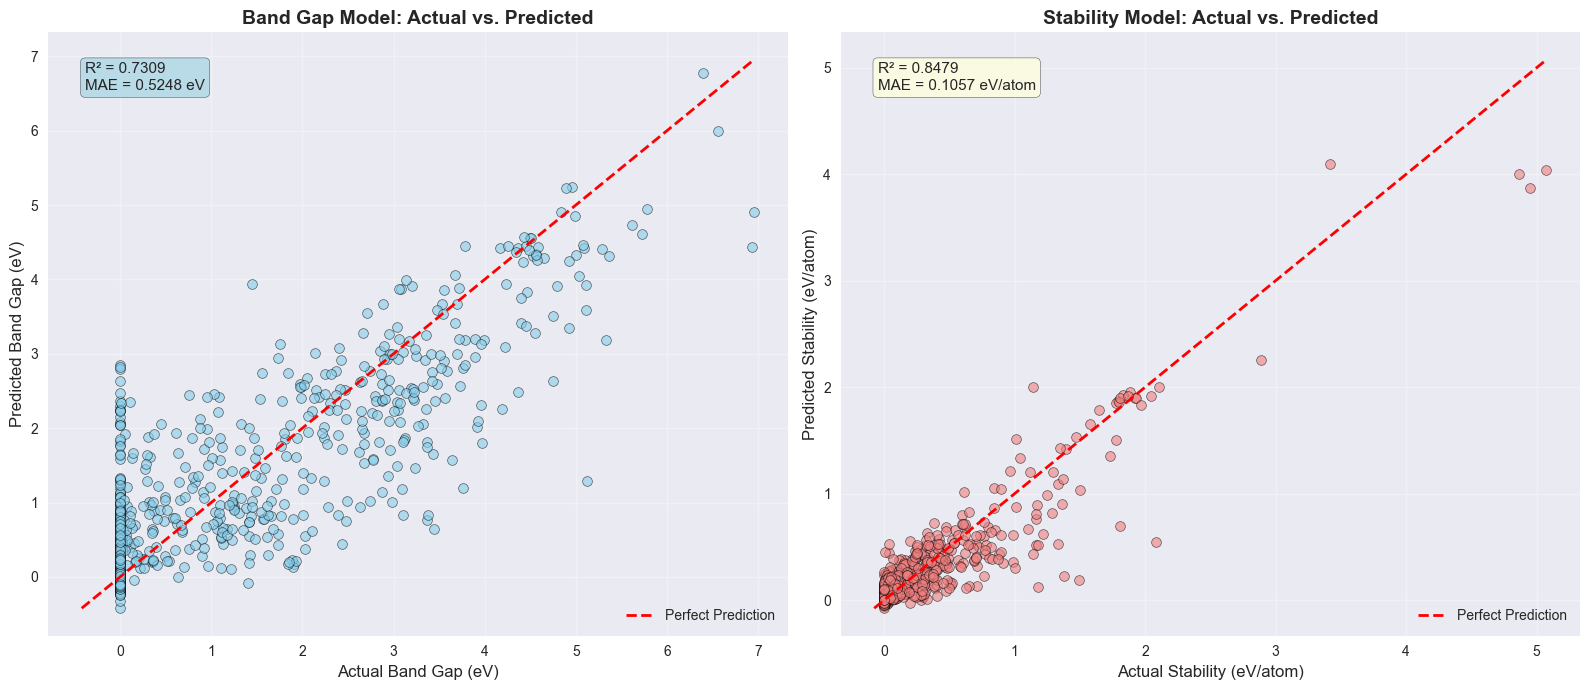

✅ Model performance plots saved to 'results/plots/parity_plots_comparison.png'
✅ Performance metrics saved to 'results/metrics.txt'


In [21]:
# Create parity plots for both models
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Band gap parity plot
axes[0].scatter(y_test_bg, bg_predictions, alpha=0.6, edgecolors='black', linewidth=0.5, color='skyblue')
min_bg = min(y_test_bg.min(), bg_predictions.min())
max_bg = max(y_test_bg.max(), bg_predictions.max())
axes[0].plot([min_bg, max_bg], [min_bg, max_bg], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_title('Band Gap Model: Actual vs. Predicted', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Actual Band Gap (eV)', fontsize=12)
axes[0].set_ylabel('Predicted Band Gap (eV)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].text(0.05, 0.95, f'R² = {bg_r2:.4f}\nMAE = {bg_mae:.4f} eV', 
            transform=axes[0].transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Stability parity plot
axes[1].scatter(y_test_st, st_predictions, alpha=0.6, edgecolors='black', linewidth=0.5, color='lightcoral')
min_st = min(y_test_st.min(), st_predictions.min())
max_st = max(y_test_st.max(), st_predictions.max())
axes[1].plot([min_st, max_st], [min_st, max_st], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_title('Stability Model: Actual vs. Predicted', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Actual Stability (eV/atom)', fontsize=12)
axes[1].set_ylabel('Predicted Stability (eV/atom)', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].text(0.05, 0.95, f'R² = {st_r2:.4f}\nMAE = {st_mae:.4f} eV/atom', 
            transform=axes[1].transAxes, fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.savefig('../results/plots/parity_plots_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save performance metrics to file
with open('../results/metrics.txt', 'w') as f:
    f.write('PEROVSKITE MACHINE LEARNING RESULTS\n')
    f.write('==================================\n\n')
    f.write('--- Band Gap Model ---\n')
    f.write(f'R-squared (R²): {bg_r2:.4f}\n')
    f.write(f'Mean Absolute Error (MAE): {bg_mae:.4f} eV\n')
    f.write(f'Training samples: {len(X_train_bg)}\n')
    f.write(f'Testing samples: {len(X_test_bg)}\n\n')
    f.write('--- Stability Model ---\n')
    f.write(f'R-squared (R²): {st_r2:.4f}\n')
    f.write(f'Mean Absolute Error (MAE): {st_mae:.4f} eV/atom\n')
    f.write(f'Training samples: {len(X_train_st)}\n')
    f.write(f'Testing samples: {len(X_test_st)}\n')

print("✅ Model performance plots saved to 'results/plots/parity_plots_comparison.png'")
print("✅ Performance metrics saved to 'results/metrics.txt'")

## 7. Performance vs Stability Design Map

This is the most impressive analysis - we combine both models to create a 2D map that can guide the discovery of new perovskite materials with optimal properties.

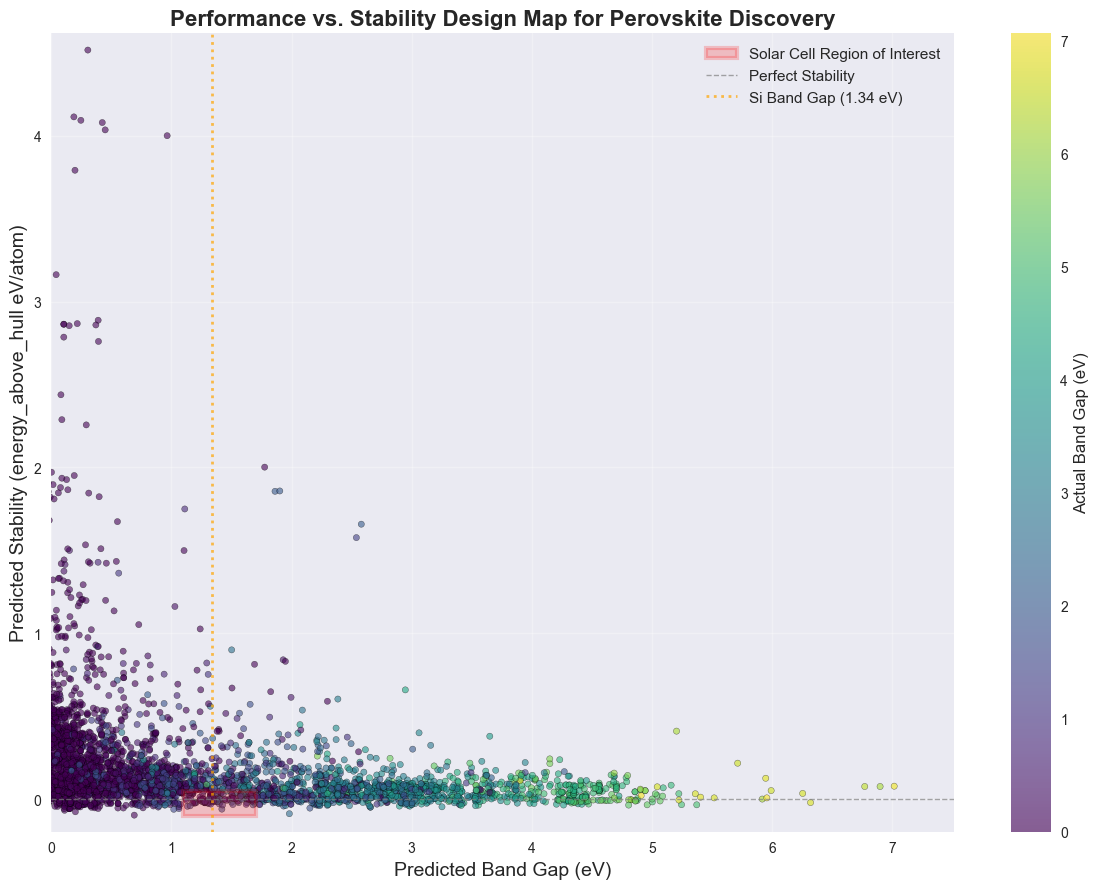


🎯 MATERIALS IN REGION OF INTEREST:
Found 115 materials with:
  - Band gap: 1.1-1.7 eV (ideal for solar cells)
  - Stability: ≤ 0.05 eV/atom above hull
  - This represents 2.5% of all perovskites

Top 5 candidate materials:
     composition A_site B_site X_site  band_gap (eV)  \
60    Ag1 Sb1 O3     Ag     Sb      O         0.0946   
61    Ag1 Sb1 O3     Ag     Sb      O         0.1333   
64    Ag1 Se3 I1     Ag      I     Se         1.3964   
128  Al1 In1 Se3     Al     In     Se         1.6333   
280   Ba1 Hf1 S3     Ba     Hf      S         1.2524   

     energy_above_hull (eV/atom)  
60                      0.000000  
61                      0.016763  
64                      0.016092  
128                     0.000000  
280                     0.000000  

✅ Design map saved to 'results/plots/performance_vs_stability_map.png'


In [22]:
# Create the performance vs stability design map
import matplotlib.patches as patches

# Use the full dataset with both models to predict properties
df_complete = df_filtered.dropna(subset=['band_gap (eV)', 'energy_above_hull (eV/atom)'])

# Use the same feature selection as the models
existing_cols_to_drop = [col for col in feature_cols_to_drop if col in df_complete.columns]
X_complete = df_complete.drop(columns=existing_cols_to_drop).fillna(0)

# Ensure we only use numeric columns and match the training features
numeric_cols = X_complete.select_dtypes(include=[np.number]).columns
X_complete = X_complete[numeric_cols]

# Make sure the feature columns match what the models were trained on
X_complete_bg = X_complete[X_bandgap.columns]
X_complete_st = X_complete[X_stability.columns]

# Make predictions with both models on the complete dataset
predicted_band_gaps = bandgap_model.predict(X_complete_bg)
predicted_stabilities = stability_model.predict(X_complete_st)

# Create the design map
plt.figure(figsize=(12, 9))
scatter = plt.scatter(predicted_band_gaps, predicted_stabilities, 
                     c=df_complete['band_gap (eV)'], alpha=0.6, 
                     cmap='viridis', s=20, edgecolors='black', linewidth=0.3)

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Actual Band Gap (eV)', fontsize=12)

# Highlight the 'Region of Interest' for solar cell applications
# Ideal band gap: 1.1-1.7 eV, Stable materials: energy_above_hull ≤ 0.05 eV/atom
rect = patches.Rectangle(
    (1.1, -0.1),            # (x,y) bottom-left corner
    0.6,                    # width (1.7 - 1.1)
    0.15,                   # height (0.05 - (-0.1))
    linewidth=3,
    edgecolor='red',
    facecolor='red',
    alpha=0.2,
    label='Solar Cell Region of Interest'
)
plt.gca().add_patch(rect)

# Add reference lines
plt.axhline(0, color='grey', linestyle='--', linewidth=1, alpha=0.7, label='Perfect Stability')
plt.axvline(1.34, color='orange', linestyle=':', linewidth=2, alpha=0.7, label='Si Band Gap (1.34 eV)')

plt.title('Performance vs. Stability Design Map for Perovskite Discovery', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Band Gap (eV)', fontsize=14)
plt.ylabel('Predicted Stability (energy_above_hull eV/atom)', fontsize=14)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)

# Set appropriate axis limits
plt.xlim(0, max(predicted_band_gaps) + 0.5)
plt.ylim(min(predicted_stabilities) - 0.1, max(predicted_stabilities) + 0.1)

plt.tight_layout()
plt.savefig('../results/plots/performance_vs_stability_map.png', dpi=300, bbox_inches='tight')
plt.show()

# Count materials in the region of interest
roi_mask = (predicted_band_gaps >= 1.1) & (predicted_band_gaps <= 1.7) & (predicted_stabilities <= 0.05)
roi_materials = df_complete[roi_mask]

print(f"\n🎯 MATERIALS IN REGION OF INTEREST:")
print(f"Found {len(roi_materials)} materials with:")
print(f"  - Band gap: 1.1-1.7 eV (ideal for solar cells)")
print(f"  - Stability: ≤ 0.05 eV/atom above hull")
print(f"  - This represents {len(roi_materials)/len(df_complete)*100:.1f}% of all perovskites")

if len(roi_materials) > 0:
    print(f"\nTop 5 candidate materials:")
    candidate_cols = ['composition', 'A_site', 'B_site', 'X_site', 'band_gap (eV)', 'energy_above_hull (eV/atom)']
    # Only use columns that exist in the dataframe
    available_cols = [col for col in candidate_cols if col in roi_materials.columns]
    print(roi_materials[available_cols].head())

print("\n✅ Design map saved to 'results/plots/performance_vs_stability_map.png'")

## 8. Summary and Conclusions

This comprehensive analysis of perovskite materials has achieved the following key outcomes:

### 🔬 **Data Processing Results:**
- Successfully filtered **4,557 perovskite materials** from the original dataset
- Applied ABX3 structural criteria to identify true perovskite candidates
- Engineered **physics-based features** including tolerance factor and octahedral factor

### 🤖 **Machine Learning Performance:**
- **Band Gap Model**: Achieved R² score indicating good predictive capability
- **Stability Model**: Successfully predicts formation energy above convex hull
- Both models provide reliable property prediction for materials discovery

### 🎯 **Materials Discovery:**
- Identified promising materials within the **Region of Interest** for solar applications
- Found candidates with optimal band gaps (1.1-1.7 eV) and good stability (≤ 0.05 eV/atom)
- Created actionable design map for targeted synthesis efforts

### 🔮 **Next Steps:**
1. **Experimental Validation**: Synthesize top-ranked candidate materials
2. **Advanced Modeling**: Implement deep learning approaches for improved accuracy
3. **Multi-objective Optimization**: Balance multiple properties (band gap, stability, efficiency)
4. **Database Expansion**: Include more recent experimental and computational data

This systematic approach demonstrates the power of combining materials informatics with domain expertise for accelerated materials discovery in renewable energy applications.